<a href="https://colab.research.google.com/github/MockaWolke/Deep_Places/blob/master/ND_Traininng_MN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MockaWolke/Deep_Places.git
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/UAL/ND_Data.zip ND_Data.zip 
!unzip -q ND_Data.zip -d Deep_Places
!rm  ND_Data.zip
!mkdir Deep_Places/model_info
!mkdir Deep_Places/model_info/logs
!mkdir Deep_Places/model_info/weights
!mkdir Deep_Places/model_info/models

import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import os
os.chdir("Deep_Places")
import ds_generator
import models
import plotting

Cloning into 'Deep_Places'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 134 (delta 11), reused 37 (delta 9), pack-reused 90
Receiving objects: 100% (134/134), 101.57 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (72/72), done.
Mounted at /content/drive


In [2]:
df = pd.read_csv("ND_Data/data.csv",index_col = 0)
train_df = df.loc[df["ds_type"]=="train"]
val_df = df.loc[df["ds_type"]=="val"]

In [3]:
df.head()

,key,easting,northing,view_direction,sequence_key,Path,City,night_name,ds_type
0,08X75PE9Ij8oqD9SH2GJZw,415481.066516,6.188003e+06,Forward,qqbnlmi5l2fv5z7ktpxqa0,Places_Data/train_val/moscow/database,moscow,Night,train
1,sf9VFjm2v6Apae8ASW3MTA,330192.964011,-4.197296e+06,Forward,ppvzgiujnoc1eoeyi2j1zk,Places_Data/train_val/melbourne/query,melbourne,Day,train
2,CrIzVu-uN3Ri8R30Exjo_g,623775.788294,5.804146e+06,Forward,E7PW3VQOLaw2vS44WjULkw,Places_Data/train_val/amsterdam/database,amsterdam,Day,train
3,tWUUxtJHfAvnGkD4wGzn2Q,411252.605886,3.716269e+06,Forward,ZWzBdDt6Rqu3obfFvHOdEA,Places_Data/train_val/phoenix/database,phoenix,Day,train
4,rJ91PhdsaVVVYSUDWpiQhg,382706.691773,6.671440e+06,Forward,qVzgSOt-Be6mKEy_zVAomw,Places_Data/train_val/helsinki/database,helsinki,Day,train


In [4]:
"""
Generate tf Datasets for training
"""

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

label_dict = {"Night":1, "Day":0}
batch_size = 64

def mapping(path,label):

    image = tf.io.read_file(path)
    image = tf.cast(tf.io.decode_jpeg(image, channels=3),tf.float32)/ 127.5 -1
    label = tf.one_hot(label,2)
    return image, label



def get_ds(df, kind = "train"): 

    path = f"ND_Data/{kind}/"
    imgs = df["key"] + ".jpg"

    #assert all([img in os.listdir(path) for img in imgs]), "Immage not found"

    image_paths = path + imgs

    labels = df["night_name"].map(label_dict)

    ds = tf.data.Dataset.from_tensor_slices((image_paths,labels))

    ds = ds.map(mapping)
    ds = ds.batch(batch_size=batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


def get_train_and_val():

    train_ds = get_ds(train_df,kind="train")
    val_ds = get_ds(val_df,kind="val")

    return train_ds,val_ds


train_ds, val_ds = get_train_and_val()

In [16]:
import tensorflow.keras.layers as layers

# some img_augmentation
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def transfer_model(number_classes,loss,architecture = tf.keras.applications.efficientnet.EfficientNetB2,name=None):

    inputs = tf.keras.Input([260,260,3])
    x = tf.keras.layers.Resizing(224,224)(inputs)

    x = img_augmentation(x) # apply image augmentaion

    print(x.shape)

    model = architecture(
        include_top=False,
        weights='imagenet',
        input_tensor= x)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(number_classes, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=name)

    return model


In [17]:
# model = models.transfer_model(2,"binary_entropy",architecture = tf.keras.applications.MobileNetV2,name="MNV2_F")
model = transfer_model(2,"binary_entropy",architecture = tf.keras.applications.MobileNetV2,name="MNV2_F")
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])

(None, 224, 224, 3)


In [18]:
log_dir = f"model_info/logs/" + model.name 
checkpoint_path = f"model_info/weights/{model.name}/"
last_model = f"model_info/models/{model.name}"

os.makedirs(log_dir)
os.makedirs(checkpoint_path)
os.makedirs(last_model)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path+ "weights",
    verbose=1,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.02,
    patience=4,
    verbose=1,
    mode='auto',
    restore_best_weights=True
) 

In [19]:
hist = model.fit(train_ds, epochs=5, validation_data=val_ds,callbacks=[tensorboard_callback,cp_callback,early_stopping_callback])

Epoch 1/5
347/347 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9785
Epoch 1: val_accuracy improved from -inf to 0.89087, saving model to model_info/weights/MNV2_F/weights
347/347 [==============================] - 49s 100ms/step - loss: 0.1191 - accuracy: 0.9785 - val_loss: 0.2686 - val_accuracy: 0.8909
Epoch 2/5
347/347 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9888
Epoch 2: val_accuracy improved from 0.89087 to 0.92560, saving model to model_info/weights/MNV2_F/weights
347/347 [==============================] - 36s 103ms/step - loss: 0.0663 - accuracy: 0.9888 - val_loss: 0.2075 - val_accuracy: 0.9256
Epoch 3/5
347/347 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9885
Epoch 3: val_accuracy did not improve from 0.92560
347/347 [==============================] - 34s 98ms/step - loss: 0.0592 - accuracy: 0.9885 - val_loss: 0.2226 - val_accuracy: 0.9209
Epoch 4/5
347/347 [==============================] - E

In [20]:
model = models.unfreeze_model(model,n_layers = 54)
model._name = "MNV2_A"
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])

In [21]:
log_dir = f"model_info/logs/" + model.name 
checkpoint_path = f"model_info/weights/{model.name}/"
last_model = f"model_info/models/{model.name}"

os.makedirs(log_dir)
os.makedirs(checkpoint_path)
os.makedirs(last_model)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path+ "weights",
    verbose=1,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.02,
    patience=4,
    verbose=1,
    mode='auto',
    restore_best_weights=True
) 

In [22]:
hist_a = model.fit(train_ds, epochs=15, validation_data=val_ds,callbacks=[tensorboard_callback,cp_callback,early_stopping_callback],initial_epoch = 5)

Epoch 6/15
347/347 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9863
Epoch 6: val_accuracy improved from -inf to 0.62029, saving model to model_info/weights/MNV2_A/weights
347/347 [==============================] - 54s 135ms/step - loss: 0.0818 - accuracy: 0.9863 - val_loss: 13.4428 - val_accuracy: 0.6203
Epoch 7/15
347/347 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9888
Epoch 7: val_accuracy did not improve from 0.62029
347/347 [==============================] - 42s 120ms/step - loss: 0.0721 - accuracy: 0.9888 - val_loss: 8.4943 - val_accuracy: 0.3797
Epoch 8/15
347/347 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9842
Epoch 8: val_accuracy did not improve from 0.62029
347/347 [==============================] - 43s 124ms/step - loss: 0.1058 - accuracy: 0.9842 - val_loss: 19.1680 - val_accuracy: 0.3797
Epoch 9/15
347/347 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8487
Epoch 9

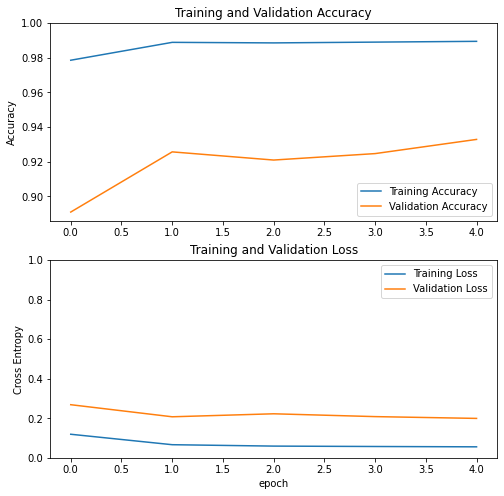

In [26]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

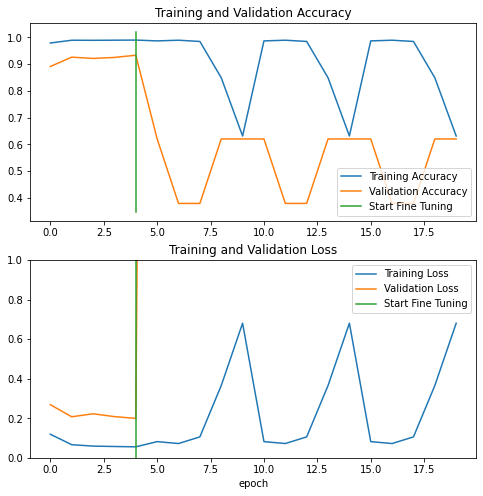

In [30]:
acc += hist_a.history['accuracy']
val_acc += hist_a.history['val_accuracy']

loss += hist_a.history['loss']
val_loss += hist_a.history['val_loss']

initial_epochs = 5

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
cp -r model_info ../drive/MyDrive/UAL/model_info

In [33]:
ls model_info 

ls: cannot access '../drive/MyDrive/UAL/model_info': No such file or directory
model_info:
logs/  models/  weights/
